## DOCKING

This jupyter notebook contains some example scripts to setup docking work for the adenosine A2B receptor.

First we prep the environment

In [1]:
!pip install oddt
!pip install vina
!jupyter labextension install jupyterlab_3dmol

  Using cached oddt-0.7-py2.py3-none-any.whl
  Using cached numpydoc-1.5.0-py3-none-any.whl (52 kB)
  Using cached sphinx-7.0.1-py3-none-any.whl (3.0 MB)
  Using cached sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
  Using cached sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
  Using cached alabaster-0.7.13-py3-none-any.whl (13 kB)
  Using cached sphinxcontrib_htmlhelp-2.0.1-py3-none-any.whl (99 kB)
  Using cached imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
  Using cached docutils-0.20.1-py3-none-any.whl (572 kB)
  Using cached sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
  Using cached sphinxcontrib_applehelp-1.0.4-py3-none-any.whl (120 kB)
  Using cached sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
  Using cached snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
  Using cached Pygments-2.15.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.12.0
    Uninstalling Pygments-2.12.

In [2]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB


import nglview
from scripts import viewer
from scripts import autodock
from scripts import box

import sys, os, shutil

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

There will be 4 stages in this notebook:
- 1.     protein preperation
- 2.     ligand preperation
- 3.     docking of a reference compound
- 4.     docking of your own compounds

# Stage 1

We have downloaded the inactive state model of the adenosine A2B receptor from gpcrdb:
https://gpcrdb.org/structure/homology_models/aa2br_human_inactive

We furthermore aligned this model to the adenosine A2A receptor, so we can use the same grid specification that was used for the docking introduction (lab 03 from CBR teaching).

In [3]:
# create a working directory
try:
    os.mkdir('workdir')
except:
    print('dir already there')

dir already there


In [4]:
# Here we prepare the AF model so we can use it for docking

command = 'bin/lepro data/A2b_AF_GPCRdb.pdb'
os.system(command)
shutil.move('pro.pdb','workdir/A2b_AF_GPCRdb-prepped.pdb')
os.remove('dock.in')

In [5]:
# Write it out to pdbqt
protein = Chem.MolFromPDBFile('workdir/A2b_AF_GPCRdb-prepped.pdb')

a = autodock.MolToPDBQTBlock(protein,flexible=False)
with open('workdir/protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [6]:
# Get the box coordinates, we use a2a as a reference
reflig = 'data/ligand-ZMA.pdb'
COG    = box.COG(reflig)
Rg     = box.Rg(reflig)

# Stage 2

Generate 3D files of the molecules

In [3]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import os

In [4]:
# This dictionary contains ligand_name:SMILES pairs

ligands = {
    'ZMA241385' : 'C1=COC(=C1)C2=NN3C(=NC(=NC3=N2)NCCC4=CC=C(C=C4)O)N',
    'Cafeine'   : 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
    'Willem000'     : 'CCCC',
    'Willem001'     : 'CCCC'
}

In [5]:
# conformer generation settings
N_CONF = 10 # number of conformers
CONF_OUTPUT_DIR = 'conformers'
CONF_FILE_PREFIX = 'confs'
PRUNE_THRS = 1.0 # determines how close the resulting conformers will be to each other

# generate conformers
def process_mol(name, smiles):
    outfile = os.path.join(CONF_OUTPUT_DIR, f"{CONF_FILE_PREFIX}_{name}.sdf")
    if os.path.exists(outfile):
        return
    #print(f"Generating conformers for compound: {name}")
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles), addCoords=True)
    param = rdDistGeom.ETKDGv2()
    param.pruneRmsThresh = PRUNE_THRS
    cids = rdDistGeom.EmbedMultipleConfs(mol, N_CONF, param)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0, mmffVariant='MMFF94s')
    os.makedirs(CONF_OUTPUT_DIR, exist_ok=True)

    res = []
    for cid in cids:
        ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=cid)
        if not ff:
            print(f"Failed to get force field for conformer: {name}_conf{cid}")
            continue
        e = ff.CalcEnergy()
        res.append((cid, e))
    if not res:
        print(f"No conformers generated for molecule: {name}")
        return
    sorted_res = sorted(res, key=lambda x:x[1])
    rdMolAlign.AlignMolConformers(mol)
    w = Chem.SDWriter(outfile)
    for cid, e in sorted_res:
        mol.SetProp('_Name', f"{name}_conf{cid}")
        mol.SetProp('CID', str(cid))
        mol.SetProp('Energy', str(e))
        w.write(mol, confId=cid)
    w.close()
    
    #print("Done.")

for name in ligands:
    process_mol(name, ligands[name])

In [6]:
# Generate conformers for each of the molecules in the smiles list

from rdkit.Chem import PandasTools

i = -1

dfs = []

for name in ligands:
    sdfile = os.path.join(CONF_OUTPUT_DIR, f"{CONF_FILE_PREFIX}_{name}.sdf")
    tmp_df = PandasTools.LoadSDF(sdfile, smilesName='SMILES', molColName='Molecule',
                                 includeFingerprints=True, removeHs=False, strictParsing=True)    

    dfs.append(tmp_df)

df = pd.concat(dfs)

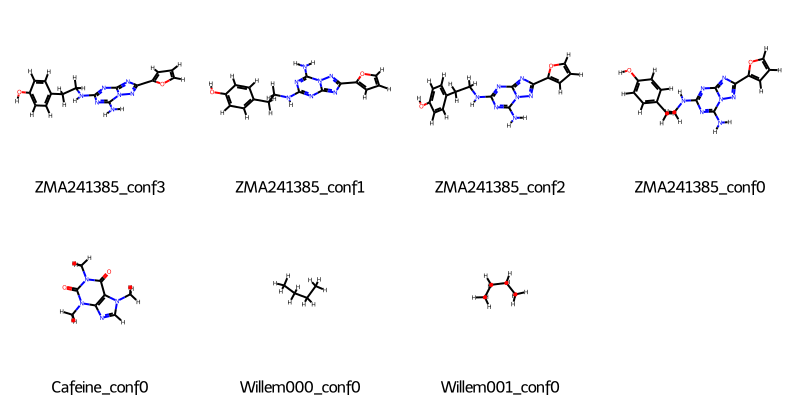

In [7]:
# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['Molecule'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['Molecule']
    #name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img

# Stage 3
Do the actual docking, this particular script selects a molecule in the dataframe of compounds and then starts doing the docking.

,CID,Energy,ID,SMILES,Molecule
0,3,-16.800403711300273,ZMA241385_conf3,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
1,1,-15.94154777738174,ZMA241385_conf1,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
2,2,-15.743627141265822,ZMA241385_conf2,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
3,0,-14.89775872003716,ZMA241385_conf0,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])N([H...,
0,0,-123.49372718344381,Cafeine_conf0,[H]c1nc2c(c(=O)n(C([H])([H])[H])c(=O)n2C([H])(...,

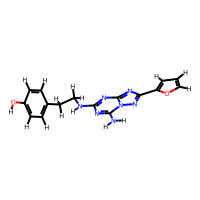
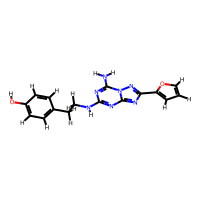
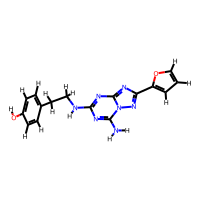
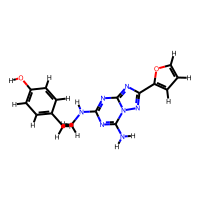
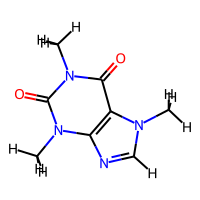

In [26]:
df

In [9]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!

molname = 'ZMA241385_conf0'

molrow = df.loc[df['ID'] == molname]#['Molecule']
m = molrow.iloc[0]['Molecule']

a = autodock.MolToPDBQTBlock(m)
#print(a)
with open('workdir/{}.pdbqt'.format(molname), 'w') as outfile:
    for line in a:
        outfile.write(line)

In [44]:
v = Vina(sf_name='vina')

v.set_receptor('workdir/protein.pdbqt')

v.set_ligand_from_file('workdir/{}.pdbqt'.format(molname))

center = {
     'center_x' : COG[0], 
     'center_y' : COG[1], 
     'center_z' : COG[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('workdir/docking_results.pdbqt', n_poses=1, overwrite=True)

Computing Vina grid ... done.
Performing docking (random seed: -874452016) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [48]:
import math

# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = autodock.MolFromPDBQTBlock('workdir/docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, 'workdir/{}_docked.pdb'.format(molname))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -8.887 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 6.52


In [24]:
# Merge the pdb files for visualisation in PLIP
# https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index

 

# Open the file that will contain all data
with open ('workdir/A2b_AF_GPCRdb-prepped_{}-complex.pdb'.format(molname), 'w') as outfile:

 

    # Reading data from file1
    with open('workdir/A2b_AF_GPCRdb-prepped.pdb') as fp:
        for line in fp:
            if 'END' in line:
                continue
            
            else:
                line = line.replace('CYX','CYS')
                line = line.replace('HSD','HIS')
                line = line.replace('HSE','HIS')
                outfile.write(line)

 

    # Reading data from file2
    with open('workdir/{}_docked.pdb'.format(molname)) as fp:
        for line in fp:
            if 'COMPND' in line:
                continue
                
            else:
                outfile.write(line)

In [23]:
# Merge the pdb files for visualisation in PLIP
# https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index

# Open the file that will contain all data
with open ('workdir/A2b_AF_GPCRdb-prepped_{}-complex.pdb'.format(molname), 'w') as outfile:

    # Reading data from file1
    with open('workdir/A2b_AF_GPCRdb-prepped.pdb') as fp:
        for line in fp:
            if 'END' in line:
                continue
            
            else:
                line = line.replace('CYX','CYS')
                line = line.replace('HSD','HIS')
                line = line.replace('HSE','HIS')
                outfile.write(line)

    # Reading data from file2
    with open('workdir/{}_docked.pdb'.format(molname)) as fp:
        for line in fp:
            if 'COMPND' in line:
                continue
                
            else:
                outfile.write(line)

In [53]:
## Visualisation seems broken?

view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('data/A2b_AF_GPCRdb.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

#ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
#view.addModels(open(ligtmp,'r').read(),format='pdb')
#ref_m = view.getModel()
#ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'workdir/{}_docked.pdb'.format(molname)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol